In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


username: eldintarofarrandi

token: fe7783d3adfd15bfb333309c12c300ed

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

eldintarofarrandi_celeba_path = kagglehub.dataset_download('eldintarofarrandi/celeba')

print('Data source import complete.')


100%|██████████| 273M/273M [00:15<00:00, 18.1MB/s]

Extracting files...


Data source import complete.


In [ ]:
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
folder_path = os.path.join(eldintarofarrandi_celeba_path, "Dataset/Images")
files_images = os.listdir(folder_path)
print(len(files_images))

5017


In [ ]:
#detect duplication

duplicates = []
# Loop untuk memeriksa file duplikasi
for file_name in files_images:
    if "(1)" in file_name:
        original_file_name = file_name.replace("(1)", "")
        if original_file_name in files_images:
            duplicates.append(file_name)

print(f'Jumlah gambar duplikat yang ditemukan: {len(duplicates)}')
print('Daftar file duplikat:')
for duplicate in duplicates:
    print(duplicate)

Jumlah gambar duplikat yang ditemukan: 17
Daftar file duplikat:
189651(1).jpg
189132(1).jpg
183018(1).jpg
183145(1).jpg
189297(1).jpg
183050(1).jpg
189512(1).jpg
182912(1).jpg
189513(1).jpg
189581(1).jpg
189324(1).jpg
182809(1).jpg
182943(1).jpg
182793(1).jpg
183005(1).jpg
183111(1).jpg
183121(1).jpg


In [ ]:
# Mengumpulkan file images yang bukan duplikat
duplicates_set = set(duplicates)

# Filter file yang bukan duplikat
filtered_images = [file for file in files_images if file not in duplicates_set]

print(f'Total gambar setelah filter duplikat: {len(filtered_images)}')

Total gambar setelah filter duplikat: 5000


In [ ]:
#membaca list attributes

attributes_path = os.path.join(eldintarofarrandi_celeba_path, 'Dataset/list_attribute.txt')

# Membaca file baris per baris
data = []
with open(attributes_path, 'r') as file:
    lines = file.readlines()

header_line = lines[1].strip().split()

for line in lines[2:]:
    parts = line.strip().split()
    if len(parts) == 41:
        data.append(parts)

attributes = pd.DataFrame(data)

# Menambahkan nama kolom id_images
attributes.columns = ['id_images'] + header_line

for col in header_line:
    attributes[col] = attributes[col].astype(int)

# Mengganti -1 dengan 0
attributes.replace(-1, 0, inplace=True)

#mapping gambar ke atribut

filtered_attributes = attributes[attributes['id_images'].isin(filtered_images)]

In [ ]:
#data preprocessing

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class GenderDataset(Dataset):
    def __init__(self, image_dir, dataframe, transform=None):
        self.image_dir = image_dir
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
#data splitting

batch_size = 128
learning_rate = 0.001
epochs = 10

filtered_attributes = filtered_attributes[['id_images', 'Male']]

# split the data into train and test sets with a 80:20 ratio
train_attributes, test_attributes = train_test_split(filtered_attributes, test_size=0.2, random_state=42)

image_dir = os.path.join(eldintarofarrandi_celeba_path, "Dataset/Images")

In [ ]:
print(train_attributes['Male'].value_counts())
print(test_attributes['Male'].value_counts())

Male
0    2357
1    1643
Name: count, dtype: int64
Male
0    596
1    404
Name: count, dtype: int64


# GoogleNet
{'learning_rate': 0.0001, 'batch_size': 8, 'num_epochs': 15}

In [ ]:
train_data = GenderDataset(image_dir, train_attributes, transform=transform)
trainloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_data = GenderDataset(image_dir, test_attributes, transform=transform)
testloader = DataLoader(test_data, batch_size=8, shuffle=False)

In [ ]:
learning_rate = 0.0001
epochs = 15

model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if i % 30 == 29:
        #     print('[Epoch %d, Batch %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 30))
        #     running_loss = 0.0

    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)
    print(f'Training Accuracy: {train_acc:.2f}%')

    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(testloader)
    test_accuracies.append(epoch_acc)
    print(f'Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc:.2f}%')

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))

model.load_state_dict(best_model_wts)

Training Accuracy: 89.17%
Test Loss: 0.1166 | Test Accuracy: 95.80%
Training Accuracy: 93.58%
Test Loss: 0.1047 | Test Accuracy: 96.10%
Training Accuracy: 96.12%
Test Loss: 0.0754 | Test Accuracy: 97.70%
Training Accuracy: 97.15%
Test Loss: 0.0817 | Test Accuracy: 97.20%
Training Accuracy: 98.30%
Test Loss: 0.0924 | Test Accuracy: 97.10%
Training Accuracy: 98.67%
Test Loss: 0.0968 | Test Accuracy: 97.30%
Training Accuracy: 98.58%
Test Loss: 0.0814 | Test Accuracy: 97.50%
Training Accuracy: 98.78%
Test Loss: 0.0836 | Test Accuracy: 97.50%
Training Accuracy: 98.67%
Test Loss: 0.1120 | Test Accuracy: 96.40%
Training Accuracy: 99.15%
Test Loss: 0.0958 | Test Accuracy: 96.90%
Training Accuracy: 98.90%
Test Loss: 0.0883 | Test Accuracy: 97.80%
Training Accuracy: 99.03%
Test Loss: 0.0894 | Test Accuracy: 97.80%
Training Accuracy: 99.38%
Test Loss: 0.1013 | Test Accuracy: 97.00%
Training Accuracy: 99.12%
Test Loss: 0.0763 | Test Accuracy: 98.00%
Training Accuracy: 99.33%
Test Loss: 0.1068 | Te

<All keys matched successfully>

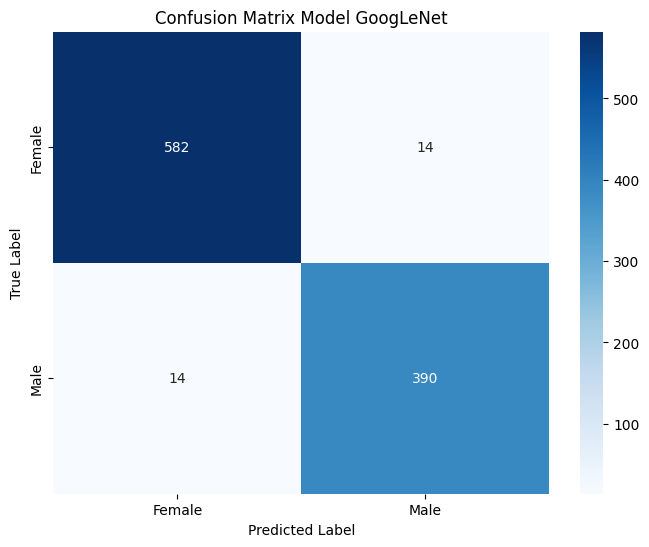

Classification Report:
              precision    recall  f1-score   support

      Female       0.98      0.98      0.98       596
        Male       0.97      0.97      0.97       404

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



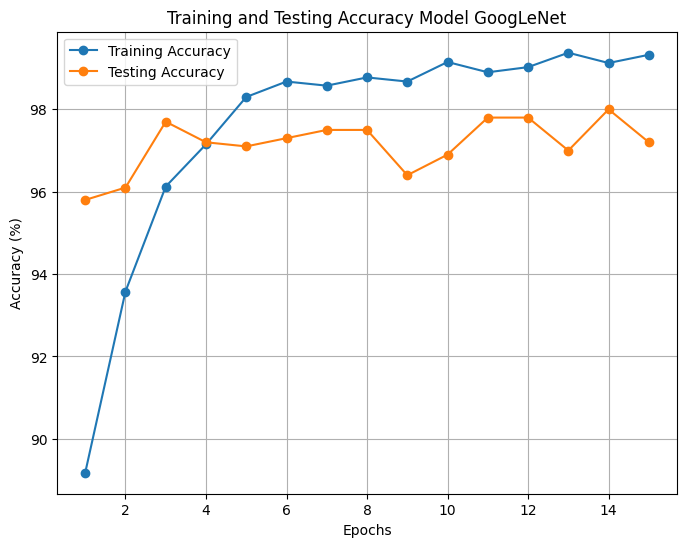

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix Model GoogLeNet')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix_GoogLeNet.png')
    plt.show()

cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, classes=['Female', 'Male'])

report = classification_report(all_labels, all_preds, target_names=['Female', 'Male'])
print("Classification Report:")
print(report)

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy', marker='o')
plt.title('Training and Testing Accuracy Model GoogLeNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.savefig('accuracy_chart_GoogLeNet.png')
plt.show()

In [ ]:
torch.save(best_model_wts, 'best_googleNet.pth')

# Resnet
{'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 15}

In [ ]:
train_data = GenderDataset(image_dir, train_attributes, transform=transform)
trainloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_data = GenderDataset(image_dir, test_attributes, transform=transform)
testloader = DataLoader(test_data, batch_size=8, shuffle=False)

In [ ]:
learning_rate = 0.00001
epochs = 15

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if i % 30 == 29:
        #     print('[Epoch %d, Batch %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 30))
        #     running_loss = 0.0

    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)
    print(f'Training Accuracy: {train_acc:.2f}%')

    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(testloader)
    test_accuracies.append(epoch_acc)
    print(f'Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc:.2f}%')

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))

model.load_state_dict(best_model_wts)

Training Accuracy: 86.47%
Test Loss: 0.1568 | Test Accuracy: 94.70%
Training Accuracy: 92.50%
Test Loss: 0.1212 | Test Accuracy: 96.10%
Training Accuracy: 93.85%
Test Loss: 0.1054 | Test Accuracy: 96.80%
Training Accuracy: 95.60%
Test Loss: 0.0973 | Test Accuracy: 96.70%
Training Accuracy: 96.40%
Test Loss: 0.1019 | Test Accuracy: 96.80%
Training Accuracy: 96.88%
Test Loss: 0.0902 | Test Accuracy: 97.20%
Training Accuracy: 97.60%
Test Loss: 0.0892 | Test Accuracy: 97.10%
Training Accuracy: 97.78%
Test Loss: 0.0930 | Test Accuracy: 97.10%
Training Accuracy: 97.53%
Test Loss: 0.0793 | Test Accuracy: 97.20%
Training Accuracy: 97.67%
Test Loss: 0.0842 | Test Accuracy: 97.50%
Training Accuracy: 98.50%
Test Loss: 0.0687 | Test Accuracy: 98.20%
Training Accuracy: 98.42%
Test Loss: 0.0736 | Test Accuracy: 97.70%
Training Accuracy: 98.60%
Test Loss: 0.0841 | Test Accuracy: 97.30%
Training Accuracy: 99.08%
Test Loss: 0.0816 | Test Accuracy: 96.90%
Training Accuracy: 99.03%
Test Loss: 0.0878 | Te

<All keys matched successfully>

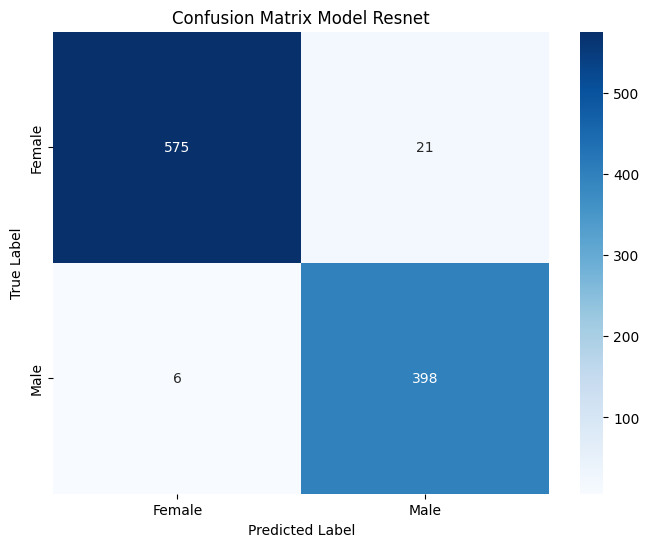

Classification Report:
              precision    recall  f1-score   support

      Female       0.99      0.96      0.98       596
        Male       0.95      0.99      0.97       404

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



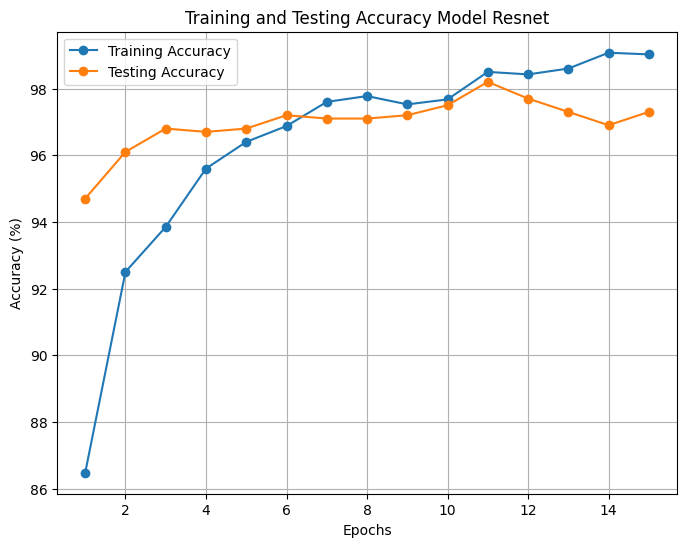

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix Model Resnet')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix_Resnet.png')
    plt.show()

cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, classes=['Female', 'Male'])

report = classification_report(all_labels, all_preds, target_names=['Female', 'Male'])
print("Classification Report:")
print(report)

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy', marker='o')
plt.title('Training and Testing Accuracy Model Resnet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.savefig('accuracy_chart_Resnet.png')
plt.show()

In [ ]:
torch.save(best_model_wts, 'best_Resnet.pth')

# VGG
[lr=1e-05, batch_size=128, epochs=25]

In [ ]:
train_data = GenderDataset(image_dir, train_attributes, transform=transform)
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_data = GenderDataset(image_dir, test_attributes, transform=transform)
testloader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
learning_rate = 0.00001
epochs = 25

model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.classifier[6] = nn.Linear(4096, 2)
# Change the device to 'cpu' to run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check for GPU availability
model = model.to(device) # Move model to the appropriate device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0

train_accuracies = []
test_accuracies = []

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print statistics every 30 mini-batches
        # if i % 30 == 29:
        #     print('[Epoch %d, Batch %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 30))
        #     running_loss = 0.0

    # Calculate training accuracy
    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)
    print(f'Training Accuracy: {train_acc:.2f}%')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(testloader)
    test_accuracies.append(epoch_acc)
    print(f'Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc:.2f}%')

    # Save the model if it has the best accuracy so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

# Total time elapsed
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))

model.load_state_dict(best_model_wts)

Training Accuracy: 79.90%
Test Loss: 0.2178 | Test Accuracy: 91.60%
Training Accuracy: 92.03%
Test Loss: 0.1712 | Test Accuracy: 93.10%
Training Accuracy: 93.65%
Test Loss: 0.1841 | Test Accuracy: 92.50%
Training Accuracy: 95.12%
Test Loss: 0.1420 | Test Accuracy: 94.50%
Training Accuracy: 96.17%
Test Loss: 0.1097 | Test Accuracy: 96.20%
Training Accuracy: 96.75%
Test Loss: 0.1256 | Test Accuracy: 95.90%
Training Accuracy: 97.00%
Test Loss: 0.1104 | Test Accuracy: 95.30%
Training Accuracy: 97.60%
Test Loss: 0.1044 | Test Accuracy: 96.30%
Training Accuracy: 97.78%
Test Loss: 0.1453 | Test Accuracy: 95.10%
Training Accuracy: 98.22%
Test Loss: 0.1134 | Test Accuracy: 96.40%
Training Accuracy: 98.30%
Test Loss: 0.1451 | Test Accuracy: 95.60%
Training Accuracy: 98.75%
Test Loss: 0.1397 | Test Accuracy: 95.40%
Training Accuracy: 98.72%
Test Loss: 0.1114 | Test Accuracy: 96.80%
Training Accuracy: 99.12%
Test Loss: 0.1085 | Test Accuracy: 97.00%
Training Accuracy: 99.42%
Test Loss: 0.1291 | Te

<All keys matched successfully>

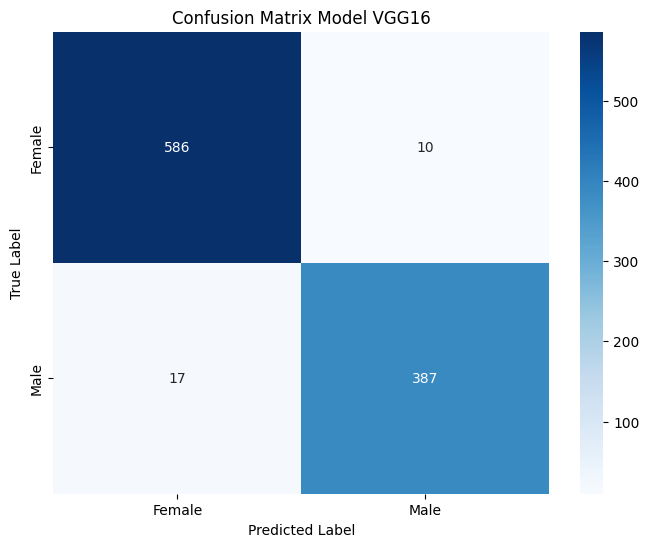

Classification Report:
              precision    recall  f1-score   support

      Female       0.97      0.98      0.98       596
        Male       0.97      0.96      0.97       404

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



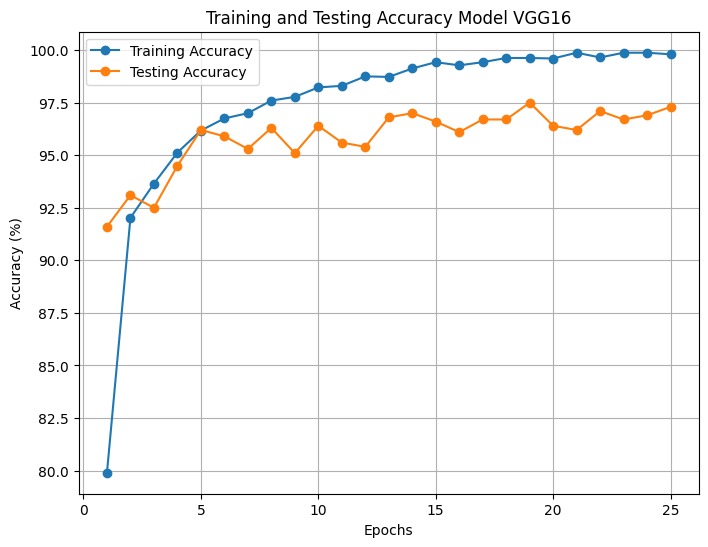

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix Model VGG16')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix_vgg16.png')
    plt.show()

# Calculate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, classes=['Female', 'Male'])

# Print classification report
report = classification_report(all_labels, all_preds, target_names=['Female', 'Male'])
print("Classification Report:")
print(report)

# Plotting accuracy chart
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy', marker='o')
plt.title('Training and Testing Accuracy Model VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.savefig('accuracy_chart_vgg16.png')
plt.show()

In [ ]:
torch.save(best_model_wts, 'best_vgg.pth')